In [1]:
from tensortrade.data.cdd import CryptoDataDownload

import pandas as pd
import numpy as np

def prepare_data(df):
    df['volume'] = np.int64(df['volume'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')
    return df

def fetch_data():
    cdd = CryptoDataDownload()
    bitfinex_data = cdd.fetch("Bitfinex", "USD", "BTC", "1h")
    bitfinex_data = bitfinex_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    bitfinex_data = prepare_data(bitfinex_data)
    return bitfinex_data

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp form "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    return prepare_data(df)

In [2]:
import ta

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    r = price.diff()
    upside = np.minimum(r, 0).abs()
    downside = np.maximum(r, 0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def sharpe(returns: np.array, risk_free_rate: float = 0) -> float:
    return (returns.mean() - risk_free_rate) / returns.std()

def maximum_drawdown(net_worth: np.array) -> float:
    n = len(net_worth)
    nav = net_worth.copy()
    mdd = 0
    peak = -np.inf
    for i in range(n):
        if nav[i] > peak:
            peak = nav[i]
        dd = 100*(peak - nav[i]) / peak
        if dd > mdd:
            mdd = dd
    return mdd

def fracdiff(s: 'pd.Series[pd.Float64Dtype]', d: float = 0.6, window: int = 25) -> 'pd.Series[pd.Float64Dtype]':
    c = np.tile([1.0, -1.0], -(-window // 2))[:window]
    w = c*binom(d, np.arange(window))
    w = w[::-1]
    frac = s.rolling(window=window, min_periods=window).agg(lambda v: np.dot(w.T, v))
    return frac

def generate_features(data):
    # Naming convention across most technical indicator libraries
    data = data.rename(columns={'date': 'Date', 
                                'open': 'Open', 
                                'high': 'High', 
                                'low': 'Low', 
                                'close': 'Close', 
                                'volume': 'Volume'})
    data = data.set_index('Date')

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'dfast': data['Close'].rolling(window=10).std().abs(),
        'dmedium': data['Close'].rolling(window=50).std().abs(),
        'dslow': data['Close'].rolling(window=100).std().abs(),
        'fast': data['Close'].rolling(window=10).mean(),
        'medium': data['Close'].rolling(window=50).mean(),
        'slow': data['Close'].rolling(window=100).mean(),
        'ema_fast': ta.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_medium': ta.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_slow': ta.trend.ema_indicator(data['Close'], window=64, fillna=True),
        'lr': np.log(data['Close']).diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_100': rsi(data['Close'], period=100),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50),
    })

    # Generate all default indicators from ta library
    df = ta.add_all_ta_features(data, 'Open', 'High', 'Low', 'Close', 'Volume', fillna=True)

    # Concatenate both manually and automatically generated features
    data = pd.concat([df, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Date': 'date', 
                                'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    return data

In [3]:
from sklearn.model_selection import train_test_split

def split_data(data):
    X = data.copy()
    y = X['close'].pct_change()

    X_train_test, X_valid, y_train_test, y_valid = \
        train_test_split(data, data['close'].pct_change(), train_size=0.67, test_size=0.33, shuffle=False)

    X_train, X_test, y_train, y_test = \
        train_test_split(X_train_test, y_train_test, train_size=0.50, test_size=0.50, shuffle=False)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [4]:
data = fetch_data()
data

date          open     high           low         close  \
0      2018-05-15 06:00 AM   8723.800000   8793.0   8714.900000   8739.000000   
1      2018-05-15 07:00 AM   8739.000000   8754.8   8719.300000   8743.000000   
2      2018-05-15 08:00 AM   8743.000000   8743.1   8653.200000   8723.700000   
3      2018-05-15 09:00 AM   8723.700000   8737.8   8701.200000   8708.100000   
4      2018-05-15 10:00 AM   8708.100000   8855.7   8695.800000   8784.400000   
...                    ...           ...      ...           ...           ...   
32457  2022-01-26 08:00 PM  37589.000000  37589.0  36709.000000  37033.000000   
32458  2022-01-26 09:00 PM  37024.000000  37216.0  36358.000000  36361.000000   
32459  2022-01-26 10:00 PM  36364.000000  36611.0  36291.695939  36539.000000   
32460  2022-01-26 11:00 PM  36542.969821  36915.0  36482.000000  36828.542176   
32461  2022-01-27 12:00 AM  36847.647615  37059.0  36741.000000  37022.883604   

         volume  
0       8988053  
1       2288904  
2       8891773  
3       2054868  
4      17309722  
...         ...  
32457  64639780  
32458  18573283  
32459  10380090  
32460   6172703  
32461   1802123  

[32462 rows x 6 columns]

In [5]:
dataset = generate_features(data)
dataset

/usr/local/lib/python3.6/dist-packages/ta/trend.py:769: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ta/trend.py:774: RuntimeWarning:

invalid value encountered in double_scalars



open     high           low         close    volume  \
0       7897.300000   7898.8   7849.800000   7877.400000   9341499   
1       7877.400000   7889.7   7661.000000   7700.000000  23679375   
2       7700.000000   7700.1   7548.100000   7605.400000  42144843   
3       7605.400000   7623.6   7441.800000   7511.100000  38711817   
4       7511.100000   7551.6   7403.000000   7489.100000  23046091   
...             ...      ...           ...           ...       ...   
32257  37589.000000  37589.0  36709.000000  37033.000000  64639780   
32258  37024.000000  37216.0  36358.000000  36361.000000  18573283   
32259  36364.000000  36611.0  36291.695939  36539.000000  10380090   
32260  36542.969821  36915.0  36482.000000  36828.542176   6172703   
32261  36847.647615  37059.0  36741.000000  37022.883604   1802123   

         volume_adi  volume_obv  volume_cmf     volume_fi     volume_em  ...  \
0     -1.219515e+08  -153103304   -0.175983 -1.548039e+08 -1.586737e+04  ...   
1     -1.375548e+08  -176782679   -0.228723 -7.327921e+08 -9.556783e+04  ...   
2     -1.479246e+08  -218927522   -0.216859 -1.197665e+09 -5.454997e+04  ...   
3     -1.571235e+08  -257639339   -0.221424 -1.548073e+09 -4.292364e+04  ...   
4     -1.534634e+08  -280685430   -0.149460 -1.399351e+09 -3.572163e+04  ...   
...             ...         ...         ...           ...           ...  ...   
32257  1.005053e+10 -4585659513   -0.292657 -1.037845e+10 -1.393383e+06  ...   
32258  1.003209e+10 -4604232796   -0.337026 -1.067885e+10 -1.672273e+06  ...   
32259  1.003779e+10 -4593852706   -0.307883 -8.889350e+09 -1.032506e+06  ...   
32260  1.004150e+10 -4587680003   -0.320548 -7.364120e+09  1.733711e+06  ...   
32261  1.004289e+10 -4585877880   -0.339618 -6.262071e+09  3.555640e+06  ...   

               slow      ema_fast    ema_medium      ema_slow        lr  \
0       8269.038800   7879.763903   7890.436477   8137.070233 -0.002523   
1       8262.218800   7819.842602   7855.811663   8123.621918 -0.022778   
2       8254.820800   7748.361735   7810.282270   8107.676628 -0.012362   
3       8246.925800   7669.274490   7755.885493   8089.320424 -0.012477   
4       8238.789800   7609.216327   7707.379040   8070.852104 -0.002933   
...             ...           ...           ...           ...       ...   
32257  36066.900673  37609.300238  37740.685007  36938.543318 -0.014104   
32258  36084.090673  37193.200159  37489.833188  36920.772754 -0.018313   
32259  36104.920673  36975.133439  37316.954426  36909.025900  0.004883   
32260  36127.416095  36926.269685  37228.152199  36906.549478  0.007893   
32261  36144.254931  36958.474324  37190.830636  36910.128989  0.005263   

           rsi_5     rsi_10    rsi_100  macd_short   macd_long  
0      54.694594  62.862413  58.177953   10.871904   31.873058  
1      83.970505  78.146122  60.860099   -5.426751   34.355233  
2      88.796304  82.430355  62.167022  -21.497215   37.504922  
3      91.852619  85.564709  63.397644  -36.146245   41.269618  
4      92.453006  86.202747  63.676078  -41.976877   44.917996  
...          ...        ...        ...         ...         ...  
32257  78.540636  62.392255  51.741769 -153.535322 -379.581165  
32258  86.124062  70.507226  52.953575 -251.199512 -368.264017  
32259  77.102573  66.296942  52.600176 -269.701779 -359.154759  
32260  63.564158  59.838768  52.029649 -234.065805 -353.169407  
32261  55.402278  55.785994  51.649830 -181.262470 -349.200978  

[32262 rows x 106 columns]

In [6]:
X_train, X_test, X_valid, y_train, y_test, y_valid = \
    split_data(data)

import os
cwd = os.getcwd()
train_csv = os.path.join(cwd, 'train.csv')
test_csv = os.path.join(cwd, 'test.csv')
valid_csv = os.path.join(cwd, 'valid.csv')
X_train.to_csv(train_csv, index=False)
X_test.to_csv(test_csv, index=False)
X_valid.to_csv(valid_csv, index=False)

In [7]:
# Things to understand here:
# Writing a Renderer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):
    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        price = list(history.close)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = price[i]
                else:
                    sell[i] = price[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(price)), price, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

In [8]:
# Things to understand here:
# execution_order
# Types of execution logic
# Exchange
# DataFeed
# renderer_feed
# default (env)

import ray
import numpy as np
import pandas as pd

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.env.default.rewards import PBR, RiskAdjustedReturns, SimpleProfit
from tensortrade.env.default.actions import BSH, ManagedRiskOrders
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.instruments import USD, BTC
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio


def create_env(config):
    data = pd.read_csv(filepath_or_buffer=config["csv_filename"], 
                       parse_dates=['date']).fillna(method='backfill').fillna(method='ffill')

    commission = 0.1  # TODO: adjust according to your commission percentage, if present
    price = Stream.source(list(data["close"]), dtype="float").rename("USD-BTC")
    bitstamp_options = ExchangeOptions(commission=commission)
    bitstamp = Exchange("bitstamp", service=execute_order, options=bitstamp_options)(price)

    cash = Wallet(bitstamp, 10000 * USD)
    asset = Wallet(bitstamp, 0 * BTC)

    portfolio = Portfolio(USD, [cash, asset])

    features = []
    for c in data.columns[1:]:
        s = Stream.source(list(data[c]), dtype="float").rename(data[c].name)
        features += [s]

    cp = Stream.select(features, lambda s: s.name == "close")

    feed = DataFeed(features)
    feed.compile()

    reward_scheme = PBR(price=price)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(list(data["date"])).rename("date"),
        Stream.source(list(data["open"]), dtype="float").rename("open"),
        Stream.source(list(data["high"]), dtype="float").rename("high"),
        Stream.source(list(data["low"]), dtype="float").rename("low"),
        Stream.source(list(data["close"]), dtype="float").rename("close"), 
        Stream.source(list(data["volume"]), dtype="float").rename("volume"), 
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment

ray.init(num_cpus=4, include_dashboard=True, ignore_reinit_error=True)

register_env("TradingEnv", create_env)

2022-01-27 18:20:54,988	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2022-01-27 18:20:54,998	WARNING services.py:1826 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=2.11gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


In [10]:
from ray.tune.suggest.optuna import OptunaSearch

# Let's define some tuning parameters
LEARNING_RATE = tune.loguniform(1e-4, 1e-2)
GAMMA = tune.uniform(0.01, 0.99)

checkpoint_metric = 'episode_reward_mean'

# Specific configuration keys that will be used during training
env_config_training = {
    "window_size": 14,  # We want to look at the last 14 samples (hours)
    "reward_window_size": 7,  # And calculate reward based on the actions taken in the next 7 hours
    "max_allowed_loss": 0.10,  # If it goes past 10% loss during the iteration, we don't want to waste time on a "loser".
    "csv_filename": train_csv  # The variable that will be used to differentiate training and validation datasets
}
# Specific configuration keys that will be used during evaluation (only the overridden ones)
env_config_evaluation = {
    "max_allowed_loss": 1.00,  # During validation runs we want to see how bad it would go. Even up to 100% loss.
    "csv_filename": test_csv,  # The variable that will be used to differentiate training and validation datasets
}

import time
start = time.time()
analysis = tune.run(
    "PPO",
    stop={
        "episode_reward_mean": 500,
        "training_iteration": 20,
    },
    config={
        "env": "TradingEnv",
        "env_config": env_config_training,
        "log_level": "ERROR",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 2,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": LEARNING_RATE,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "model": {
            "use_lstm": True,
            "lstm_cell_size": 512
        },
        "gamma": GAMMA,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        #"vf_share_layers": True,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01,
        "evaluation_interval": 1,  # Run evaluation on every iteration
        "evaluation_config": {
            "env_config": env_config_evaluation,  # The dictionary we built before (only the overriding keys to use in evaluation)
            "explore": False,  # We don't want to explore during evaluation. All actions have to be repeatable.
        },
    },
    metric=checkpoint_metric,
    mode="max",
    search_alg=OptunaSearch(),
    num_samples=10,  # Have ten samples for each hyperparameter combination. More to averages out randomness. Less runs faster
    keep_checkpoints_num=10,  # Keep the last 2 checkpoints
    checkpoint_freq=1,  # Do a checkpoint on each iteration (slower but you can pick more finely the checkpoint to use later)
)
taken = time.time() - start
print(f"Time taken: {taken:.2f} seconds.")
print(f"Best config: {analysis.best_config}")

[I 2022-01-27 18:20:57,063] A new study created in memory with name: optuna


2022-01-27 18:20:58,994	ERROR syncer.py:111 -- Log sync requires rsync to be installed.
(PPO pid=3003) 2022-01-27 18:21:04,046	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPO pid=3003) 2022-01-27 18:21:04,046	INFO trainer.py:745 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(PPO pid=3001) 2022-01-27 18:21:04,265	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPO pid=3001) 2022-01-27 18:21:04,265	INFO trainer.py:745 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=3000) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=3000) 
(RolloutW

(PPO pid=3001) 2022-01-27 18:21:13,898	INFO trainable.py:127 -- Trainable.setup took 10.380 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=3001) 2022-01-27 18:21:13,898	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Result for PPO_TradingEnv_dff87f7e:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-01-27_18-24-32
  done: false
  episode_len_mean: 18.35483870967742
  episode_media: {}
  episode_reward_max: 865.8999999999978
  episode_reward_mean: 18.110599078341323
  episode_reward_min: -629.9000000000015
  episodes_this_iter: 217
  episodes_total: 217
  evaluation:
    custom_metrics: {}
    episode_len_mean: 17.9
    episode_media: {}
    episode_reward_max: 190.0
    episode_reward_mean: 134.1
    episode_reward_min: -33.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 25
      - 16
      - 16
      - 16
      - 21
      - 16
      - 16
      - 16
      - 16
      - 21
      episode_reward:
      - -33.0
      - 142.0
      - 142.0
      - 142.0
      - 190.0
      - 142.0
      - 142.0
      - 142.0
      - 142.0
      - 190.0
    off_policy_estimator: {}
    policy_reward_max: {}
    policy_reward_mean: {}
    policy_reward_min: {}
    sampler_perf:
 

Result for PPO_TradingEnv_e0375eec:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-01-27_18-24-46
  done: false
  episode_len_mean: 17.711111111111112
  episode_media: {}
  episode_reward_max: 794.1000000000004
  episode_reward_mean: 34.56044444444436
  episode_reward_min: -651.7999999999993
  episodes_this_iter: 225
  episodes_total: 225
  evaluation:
    custom_metrics: {}
    episode_len_mean: 17.4
    episode_media: {}
    episode_reward_max: 52.0
    episode_reward_mean: -123.74599999999991
    episode_reward_min: -385.4599999999991
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 57
      - 13
      - 13
      - 13
      - 13
      - 13
      - 13
      - 13
      - 13
      - 13
      episode_reward:
      - -385.4599999999991
      - -212.0
      - -212.0
      - -212.0
      - -212.0
      - -212.0
      - 52.0
      - 52.0
      - 52.0
      - 52.0
    off_policy_estimator: {}
    policy_reward_max: {}
    policy_reward_mean: {}
    p

Result for PPO_TradingEnv_dff87f7e:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-01-27_18-27-34
  done: false
  episode_len_mean: 18.153846153846153
  episode_media: {}
  episode_reward_max: 899.899999999996
  episode_reward_mean: 254.02669683257838
  episode_reward_min: -422.59999999999854
  episodes_this_iter: 221
  episodes_total: 438
  evaluation:
    custom_metrics: {}
    episode_len_mean: 95.4
    episode_media: {}
    episode_reward_max: 1453.7200000000012
    episode_reward_mean: 565.7840000000008
    episode_reward_min: 311.02000000000044
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 364
      - 93
      - 73
      - 73
      - 66
      - 57
      - 57
      - 57
      - 57
      - 57
      episode_reward:
      - 576.3000000000029
      - 1453.7200000000012
      - 751.3500000000004
      - 751.3500000000004
      - 570.0200000000004
      - 311.02000000000044
      - 311.02000000000044
      - 311.02000000000044
      - 311.020

Result for PPO_TradingEnv_e0375eec:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-01-27_18-28-01
  done: false
  episode_len_mean: 17.20258620689655
  episode_media: {}
  episode_reward_max: 943.4999999999982
  episode_reward_mean: 248.54999999999885
  episode_reward_min: -563.6999999999989
  episodes_this_iter: 232
  episodes_total: 457
  evaluation:
    custom_metrics: {}
    episode_len_mean: 337.1
    episode_media: {}
    episode_reward_max: 2708.800000000003
    episode_reward_mean: 1240.8010000000017
    episode_reward_min: 309.40000000000146
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1067
      - 932
      - 421
      - 252
      - 199
      - 120
      - 95
      - 95
      - 95
      - 95
      episode_reward:
      - 2708.800000000003
      - 1267.3100000000031
      - 1504.5000000000036
      - 770.4000000000015
      - 309.40000000000146
      - 1010.4000000000015
      - 1209.300000000001
      - 1209.300000000001
      - 1

Result for PPO_TradingEnv_dff87f7e:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-01-27_18-30-39
  done: false
  episode_len_mean: 16.72689075630252
  episode_media: {}
  episode_reward_max: 1007.2999999999975
  episode_reward_mean: 491.2117647058804
  episode_reward_min: -221.20000000000618
  episodes_this_iter: 238
  episodes_total: 676
  evaluation:
    custom_metrics: {}
    episode_len_mean: 173.9
    episode_media: {}
    episode_reward_max: 1283.0200000000004
    episode_reward_mean: 872.1330000000005
    episode_reward_min: 429.02000000000044
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 939
      - 192
      - 93
      - 82
      - 82
      - 82
      - 82
      - 73
      - 57
      - 57
      episode_reward:
      - 1166.7800000000007
      - 547.4200000000019
      - 1283.0200000000004
      - 1041.6800000000003
      - 1041.6800000000003
      - 1041.6800000000003
      - 1041.6800000000003
      - 699.3500000000004
      - 42

Result for PPO_TradingEnv_e0375eec:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-01-27_18-31-28
  done: false
  episode_len_mean: 16.454918032786885
  episode_media: {}
  episode_reward_max: 1023.5000000000018
  episode_reward_mean: 480.5942622950799
  episode_reward_min: -275.5000000000018
  episodes_this_iter: 244
  episodes_total: 701
  evaluation:
    custom_metrics: {}
    episode_len_mean: 638.9
    episode_media: {}
    episode_reward_max: 2694.6000000000013
    episode_reward_mean: 1768.161000000003
    episode_reward_min: 1209.300000000001
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1110
      - 1074
      - 1067
      - 932
      - 426
      - 426
      - 421
      - 419
      - 419
      - 95
      episode_reward:
      - 2694.6000000000013
      - 2462.9000000000033
      - 2622.800000000003
      - 1267.3100000000031
      - 1431.400000000005
      - 1431.400000000005
      - 1504.5000000000036
      - 1528.7000000000025
  

Result for PPO_TradingEnv_dff87f7e:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-01-27_18-33-47
  done: true
  episode_len_mean: 16.471311475409838
  episode_media: {}
  episode_reward_max: 1038.899999999996
  episode_reward_mean: 558.861065573768
  episode_reward_min: -267.9000000000051
  episodes_this_iter: 244
  episodes_total: 920
  evaluation:
    custom_metrics: {}
    episode_len_mean: 237.1
    episode_media: {}
    episode_reward_max: 1613.8200000000015
    episode_reward_mean: 1057.1380000000013
    episode_reward_min: 411.4200000000019
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1046
      - 360
      - 192
      - 192
      - 135
      - 93
      - 93
      - 89
      - 89
      - 82
      episode_reward:
      - 1613.8200000000015
      - 411.4200000000019
      - 547.4200000000019
      - 547.4200000000019
      - 821.4200000000019
      - 1447.0200000000004
      - 1447.0200000000004
      - 1280.0800000000017
      - 128

(PPO pid=2999) 2022-01-27 18:33:56,441	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPO pid=2999) 2022-01-27 18:33:56,441	INFO trainer.py:745 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=2997) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=2997) 
(RolloutWorker pid=2997) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=2997) 
(PPO pid=2999) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(PPO pid=2999) 
(PPO pid=2999) WARN: Box bound precision lowered by casting to float32
(PPO pid=2999) 
(RolloutWorker pid=3492) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=3492) 
(RolloutWorker pid=3492) WARN: Box bound precision lowered by casting to

(PPO pid=2999) 2022-01-27 18:34:06,435	INFO trainable.py:127 -- Trainable.setup took 11.336 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=2999) 2022-01-27 18:34:06,436	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Result for PPO_TradingEnv_e0375eec:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-01-27_18-34-56
  done: true
  episode_len_mean: 15.820717131474103
  episode_media: {}
  episode_reward_max: 1282.2000000000007
  episode_reward_mean: 531.0657370517905
  episode_reward_min: -134.10000000000218
  episodes_this_iter: 251
  episodes_total: 952
  evaluation:
    custom_metrics: {}
    episode_len_mean: 726.3
    episode_media: {}
    episode_reward_max: 2694.6000000000013
    episode_reward_mean: 1744.7540000000038
    episode_reward_min: 1369.3200000000015
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1110
      - 1075
      - 1075
      - 939
      - 939
      - 426
      - 426
      - 426
      - 426
      - 421
      episode_reward:
      - 2694.6000000000013
      - 2442.100000000004
      - 2442.100000000004
      - 1369.3200000000015
      - 1369.3200000000015
      - 1431.400000000005
      - 1431.400000000005
      - 1431.400000000005
 

(PPO pid=3553) 2022-01-27 18:35:02,798	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPO pid=3553) 2022-01-27 18:35:02,798	INFO trainer.py:745 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=3583) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=3583) 
(RolloutWorker pid=3583) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=3583) 
(RolloutWorker pid=3584) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=3584) 
(RolloutWorker pid=3584) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=3584) 
(PPO pid=3553) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(PPO pid=3553) 
(PPO pid=3553) WARN: Box bound precision lowered by 

(PPO pid=3553) 2022-01-27 18:35:13,234	INFO trainable.py:127 -- Trainable.setup took 11.233 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=3553) 2022-01-27 18:35:13,234	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Result for PPO_TradingEnv_e059f704:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-01-27_18-37-17
  done: false
  episode_len_mean: 18.164383561643834
  episode_media: {}
  episode_reward_max: 1018.8000000000011
  episode_reward_mean: 18.973059360730254
  episode_reward_min: -726.8000000000029
  episodes_this_iter: 219
  episodes_total: 219
  evaluation:
    custom_metrics: {}
    episode_len_mean: 17.0
    episode_media: {}
    episode_reward_max: -51.97999999999956
    episode_reward_mean: -127.3819999999996
    episode_reward_min: -189.97999999999956
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 21
      - 13
      - 21
      - 13
      - 13
      - 21
      - 13
      - 21
      - 13
      - 21
      episode_reward:
      - -116.0
      - -189.97999999999956
      - -51.97999999999956
      - -189.97999999999956
      - -189.97999999999956
      - -51.97999999999956
      - -189.97999999999956
      - -51.97999999999956
      - -189.9799

Result for PPO_TradingEnv_aab009ac:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-01-27_18-38-42
  done: false
  episode_len_mean: 17.914414414414413
  episode_media: {}
  episode_reward_max: 673.5999999999985
  episode_reward_mean: 2.603603603603653
  episode_reward_min: -726.5000000000036
  episodes_this_iter: 222
  episodes_total: 222
  evaluation:
    custom_metrics: {}
    episode_len_mean: 13.4
    episode_media: {}
    episode_reward_max: 168.02000000000044
    episode_reward_mean: 103.21800000000039
    episode_reward_min: -116.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 21
      - 11
      - 11
      - 13
      - 13
      - 13
      - 13
      - 13
      - 13
      - 13
      episode_reward:
      - -116.0
      - 168.02000000000044
      - 168.02000000000044
      - 116.02000000000044
      - 116.02000000000044
      - 116.02000000000044
      - 116.02000000000044
      - 116.02000000000044
      - 116.02000000000044
      - 1

Result for PPO_TradingEnv_e059f704:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-01-27_18-40-25
  done: false
  episode_len_mean: 18.328767123287673
  episode_media: {}
  episode_reward_max: 955.1000000000022
  episode_reward_mean: 299.2694063926934
  episode_reward_min: -448.100000000004
  episodes_this_iter: 219
  episodes_total: 438
  evaluation:
    custom_metrics: {}
    episode_len_mean: 224.1
    episode_media: {}
    episode_reward_max: 2712.0000000000036
    episode_reward_mean: 1199.592000000001
    episode_reward_min: 383.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1067
      - 360
      - 199
      - 95
      - 95
      - 95
      - 95
      - 89
      - 89
      - 57
      episode_reward:
      - 2712.0000000000036
      - 956.4000000000015
      - 503.40000000000146
      - 1281.2800000000007
      - 1281.2800000000007
      - 1281.2800000000007
      - 1281.2800000000007
      - 1158.0
      - 1158.0
      - 383.0
    of

Result for PPO_TradingEnv_aab009ac:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-01-27_18-41-59
  done: false
  episode_len_mean: 17.24137931034483
  episode_media: {}
  episode_reward_max: 891.4000000000015
  episode_reward_mean: 219.67543103448182
  episode_reward_min: -370.09999999999854
  episodes_this_iter: 232
  episodes_total: 454
  evaluation:
    custom_metrics: {}
    episode_len_mean: 288.4
    episode_media: {}
    episode_reward_max: 2708.800000000003
    episode_reward_mean: 1176.4260000000015
    episode_reward_min: 409.40000000000146
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1067
      - 426
      - 419
      - 360
      - 199
      - 89
      - 89
      - 89
      - 73
      - 73
      episode_reward:
      - 2708.800000000003
      - 1428.2000000000044
      - 1570.7000000000025
      - 838.4000000000015
      - 409.40000000000146
      - 1110.0200000000004
      - 1110.0200000000004
      - 1110.0200000000004
      -

Result for PPO_TradingEnv_e059f704:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-01-27_18-43-47
  done: false
  episode_len_mean: 16.6625
  episode_media: {}
  episode_reward_max: 979.4999999999982
  episode_reward_mean: 470.6504166666647
  episode_reward_min: -196.60000000000036
  episodes_this_iter: 240
  episodes_total: 678
  evaluation:
    custom_metrics: {}
    episode_len_mean: 355.1
    episode_media: {}
    episode_reward_max: 3004.3000000000065
    episode_reward_mean: 1305.6820000000012
    episode_reward_min: 958.4000000000015
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1087
      - 939
      - 360
      - 360
      - 360
      - 89
      - 89
      - 89
      - 89
      - 89
      episode_reward:
      - 3004.3000000000065
      - 1317.7000000000025
      - 1028.0200000000004
      - 958.4000000000015
      - 958.4000000000015
      - 1158.0
      - 1158.0
      - 1158.0
      - 1158.0
      - 1158.0
    off_policy_estimato

Result for PPO_TradingEnv_aab009ac:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-01-27_18-45-25
  done: false
  episode_len_mean: 16.024
  episode_media: {}
  episode_reward_max: 967.0
  episode_reward_mean: 476.22599999999784
  episode_reward_min: -268.00000000000364
  episodes_this_iter: 250
  episodes_total: 704
  evaluation:
    custom_metrics: {}
    episode_len_mean: 499.9
    episode_media: {}
    episode_reward_max: 2854.420000000002
    episode_reward_mean: 1502.7320000000025
    episode_reward_min: 838.4000000000015
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1070
      - 1067
      - 426
      - 421
      - 421
      - 419
      - 360
      - 360
      - 360
      - 95
      episode_reward:
      - 2553.300000000003
      - 2854.420000000002
      - 1431.400000000005
      - 1446.5000000000036
      - 1446.5000000000036
      - 1570.7000000000025
      - 838.4000000000015
      - 838.4000000000015
      - 838.4000000000015
  

Result for PPO_TradingEnv_e059f704:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-01-27_18-47-06
  done: true
  episode_len_mean: 16.711297071129707
  episode_media: {}
  episode_reward_max: 967.0
  episode_reward_mean: 526.8376569037633
  episode_reward_min: -125.4000000000051
  episodes_this_iter: 239
  episodes_total: 917
  evaluation:
    custom_metrics: {}
    episode_len_mean: 356.1
    episode_media: {}
    episode_reward_max: 3302.2400000000034
    episode_reward_mean: 1711.0800000000017
    episode_reward_min: 1028.0200000000004
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1138
      - 1067
      - 426
      - 360
      - 95
      - 95
      - 95
      - 95
      - 95
      - 95
      episode_reward:
      - 3302.2400000000034
      - 2622.800000000003
      - 1593.8200000000033
      - 1028.0200000000004
      - 1427.3200000000015
      - 1427.3200000000015
      - 1427.3200000000015
      - 1427.3200000000015
      - 1427.32000

(PPO pid=3782) 2022-01-27 18:47:12,792	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPO pid=3782) 2022-01-27 18:47:12,792	INFO trainer.py:745 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=3812) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=3812) 
(RolloutWorker pid=3812) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=3812) 
(PPO pid=3782) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(PPO pid=3782) 
(PPO pid=3782) WARN: Box bound precision lowered by casting to float32
(PPO pid=3782) 
(RolloutWorker pid=3813) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=3813) 
(RolloutWorker pid=3813) WARN: Box bound precision lowered by casting to

(PPO pid=3782) 2022-01-27 18:47:23,812	INFO trainable.py:127 -- Trainable.setup took 11.839 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=3782) 2022-01-27 18:47:23,813	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Result for PPO_TradingEnv_aab009ac:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-01-27_18-48-50
  done: true
  episode_len_mean: 15.806324110671937
  episode_media: {}
  episode_reward_max: 991.2999999999938
  episode_reward_mean: 522.6312252964402
  episode_reward_min: -44.80000000000655
  episodes_this_iter: 253
  episodes_total: 957
  evaluation:
    custom_metrics: {}
    episode_len_mean: 609.4
    episode_media: {}
    episode_reward_max: 2854.420000000002
    episode_reward_mean: 1774.952000000003
    episode_reward_min: 838.4000000000015
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1070
      - 1070
      - 1067
      - 426
      - 421
      - 421
      - 421
      - 419
      - 419
      - 360
      episode_reward:
      - 2553.300000000003
      - 2591.100000000002
      - 2854.420000000002
      - 1431.400000000005
      - 1446.5000000000036
      - 1446.5000000000036
      - 1446.5000000000036
      - 1570.7000000000025
     

(PPO pid=3901) 2022-01-27 18:48:57,187	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPO pid=3901) 2022-01-27 18:48:57,187	INFO trainer.py:745 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=3932) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=3932) 
(RolloutWorker pid=3932) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=3932) 
(RolloutWorker pid=3931) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=3931) 
(RolloutWorker pid=3931) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=3931) 
(PPO pid=3901) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(PPO pid=3901) 
(PPO pid=3901) WARN: Box bound precision lowered by 


(PPO pid=3901) 2022-01-27 18:49:08,192	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Result for PPO_TradingEnv_d362fcba:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-01-27_18-50-48
  done: false
  episode_len_mean: 17.75111111111111
  episode_media: {}
  episode_reward_max: 796.2000000000007
  episode_reward_mean: 29.082666666666555
  episode_reward_min: -743.0
  episodes_this_iter: 225
  episodes_total: 225
  evaluation:
    custom_metrics: {}
    episode_len_mean: 14.6
    episode_media: {}
    episode_reward_max: 94.0
    episode_reward_mean: -107.2
    episode_reward_min: -170.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 29
      - 13
      - 13
      - 13
      - 13
      - 13
      - 13
      - 13
      - 13
      - 13
      episode_reward:
      - -100.0
      - 94.0
      - -170.0
      - -128.0
      - -128.0
      - -128.0
      - -128.0
      - -128.0
      - -128.0
      - -128.0
    off_policy_estimator: {}
    policy_reward_max: {}
    policy_reward_mean: {}
    policy_reward_min: {}
    sampler_perf:
    

Result for PPO_TradingEnv_8673c860:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-01-27_18-52-31
  done: false
  episode_len_mean: 18.24770642201835
  episode_media: {}
  episode_reward_max: 659.9000000000069
  episode_reward_mean: -21.7422018348624
  episode_reward_min: -701.5
  episodes_this_iter: 218
  episodes_total: 218
  evaluation:
    custom_metrics: {}
    episode_len_mean: 17.6
    episode_media: {}
    episode_reward_max: -16.0
    episode_reward_mean: -106.6
    episode_reward_min: -170.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 27
      - 21
      - 13
      - 21
      - 13
      - 13
      - 21
      - 13
      - 21
      - 13
      episode_reward:
      - -16.0
      - -50.0
      - -170.0
      - -50.0
      - -170.0
      - -170.0
      - -50.0
      - -170.0
      - -50.0
      - -170.0
    off_policy_estimator: {}
    policy_reward_max: {}
    policy_reward_mean: {}
    policy_reward_min: {}
    sampler_perf:
      m

Result for PPO_TradingEnv_d362fcba:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-01-27_18-54-04
  done: false
  episode_len_mean: 17.69333333333333
  episode_media: {}
  episode_reward_max: 919.4999999999982
  episode_reward_mean: 260.399999999999
  episode_reward_min: -394.7999999999993
  episodes_this_iter: 225
  episodes_total: 450
  evaluation:
    custom_metrics: {}
    episode_len_mean: 417.5
    episode_media: {}
    episode_reward_max: 2529.300000000001
    episode_reward_mean: 1338.7060000000015
    episode_reward_min: 409.40000000000146
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1075
      - 1074
      - 421
      - 419
      - 360
      - 360
      - 199
      - 89
      - 89
      - 89
      episode_reward:
      - 2470.7000000000025
      - 2529.300000000001
      - 1452.1000000000022
      - 1470.7000000000025
      - 862.4000000000015
      - 862.4000000000015
      - 409.40000000000146
      - 1110.0200000000004
      - 

Result for PPO_TradingEnv_8673c860:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-01-27_18-55-48
  done: false
  episode_len_mean: 17.813333333333333
  episode_media: {}
  episode_reward_max: 1173.4000000000015
  episode_reward_mean: 259.80266666666574
  episode_reward_min: -674.2000000000007
  episodes_this_iter: 225
  episodes_total: 443
  evaluation:
    custom_metrics: {}
    episode_len_mean: 309.0
    episode_media: {}
    episode_reward_max: 2363.7000000000007
    episode_reward_mean: 1286.4820000000016
    episode_reward_min: 569.4200000000019
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1070
      - 426
      - 421
      - 419
      - 199
      - 199
      - 89
      - 89
      - 89
      - 89
      episode_reward:
      - 2363.7000000000007
      - 1537.0000000000036
      - 1504.5000000000036
      - 1504.7000000000025
      - 569.4200000000019
      - 569.4200000000019
      - 1204.0200000000004
      - 1204.0200000000004
     

Result for PPO_TradingEnv_d362fcba:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-01-27_18-57-32
  done: false
  episode_len_mean: 16.46090534979424
  episode_media: {}
  episode_reward_max: 967.0
  episode_reward_mean: 467.98847736625333
  episode_reward_min: -185.70000000000073
  episodes_this_iter: 243
  episodes_total: 693
  evaluation:
    custom_metrics: {}
    episode_len_mean: 598.7
    episode_media: {}
    episode_reward_max: 2694.6000000000013
    episode_reward_mean: 1479.4500000000019
    episode_reward_min: 409.40000000000146
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1110
      - 1075
      - 1070
      - 939
      - 419
      - 360
      - 360
      - 360
      - 199
      - 95
      episode_reward:
      - 2694.6000000000013
      - 2508.500000000002
      - 2591.100000000002
      - 1223.7000000000025
      - 1570.7000000000025
      - 862.4000000000015
      - 862.4000000000015
      - 862.4000000000015
      - 409.40

Result for PPO_TradingEnv_8673c860:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-01-27_18-59-13
  done: false
  episode_len_mean: 16.790794979079497
  episode_media: {}
  episode_reward_max: 967.0
  episode_reward_mean: 498.79958158995635
  episode_reward_min: -52.30000000000109
  episodes_this_iter: 239
  episodes_total: 682
  evaluation:
    custom_metrics: {}
    episode_len_mean: 550.9
    episode_media: {}
    episode_reward_max: 2698.800000000003
    episode_reward_mean: 1281.2030000000022
    episode_reward_min: 375.4200000000019
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1087
      - 1070
      - 932
      - 421
      - 360
      - 360
      - 360
      - 360
      - 360
      - 199
      episode_reward:
      - 2698.800000000003
      - 2459.100000000002
      - 1462.1100000000024
      - 1504.5000000000036
      - 862.4200000000019
      - 862.4200000000019
      - 862.4200000000019
      - 862.4200000000019
      - 862.42000

Result for PPO_TradingEnv_d362fcba:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-01-27_19-01-04
  done: true
  episode_len_mean: 15.749019607843136
  episode_media: {}
  episode_reward_max: 1351.599999999995
  episode_reward_mean: 531.4643137254877
  episode_reward_min: -61.50000000000182
  episodes_this_iter: 255
  episodes_total: 948
  evaluation:
    custom_metrics: {}
    episode_len_mean: 727.4
    episode_media: {}
    episode_reward_max: 2731.0000000000036
    episode_reward_mean: 1815.540000000002
    episode_reward_min: 862.4000000000015
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1110
      - 1087
      - 1074
      - 1070
      - 1067
      - 426
      - 360
      - 360
      - 360
      - 360
      episode_reward:
      - 2694.6000000000013
      - 2731.0000000000036
      - 2529.300000000001
      - 2591.100000000002
      - 2622.800000000003
      - 1537.0000000000036
      - 862.4000000000015
      - 862.4000000000015
   

(PPO pid=4130) 2022-01-27 19:01:12,203	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPO pid=4130) 2022-01-27 19:01:12,203	INFO trainer.py:745 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=4160) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=4160) 
(RolloutWorker pid=4160) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=4160) 
(RolloutWorker pid=4161) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=4161) 
(RolloutWorker pid=4161) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=4161) 
(PPO pid=4130) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(PPO pid=4130) 
(PPO pid=4130) WARN: Box bound precision lowered by 

(PPO pid=4130) 2022-01-27 19:01:23,461	INFO trainable.py:127 -- Trainable.setup took 12.088 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=4130) 2022-01-27 19:01:23,461	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Result for PPO_TradingEnv_8673c860:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-01-27_19-02-38
  done: true
  episode_len_mean: 16.157894736842106
  episode_media: {}
  episode_reward_max: 967.0
  episode_reward_mean: 525.5898785425078
  episode_reward_min: -232.40000000000146
  episodes_this_iter: 247
  episodes_total: 929
  evaluation:
    custom_metrics: {}
    episode_len_mean: 656.1
    episode_media: {}
    episode_reward_max: 2698.800000000003
    episode_reward_mean: 1703.2170000000028
    episode_reward_min: 862.4200000000019
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1087
      - 1070
      - 1070
      - 932
      - 421
      - 421
      - 421
      - 419
      - 360
      - 360
      episode_reward:
      - 2698.800000000003
      - 2591.100000000002
      - 2591.100000000002
      - 1318.1100000000024
      - 1504.5000000000036
      - 1504.5000000000036
      - 1504.5000000000036
      - 1594.720000000003
      - 862.420

(PPO pid=4249) 2022-01-27 19:02:45,145	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPO pid=4249) 2022-01-27 19:02:45,145	INFO trainer.py:745 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=4279) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=4279) 
(RolloutWorker pid=4279) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=4279) 
(RolloutWorker pid=4280) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=4280) 
(RolloutWorker pid=4280) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=4280) 
(PPO pid=4249) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(PPO pid=4249) 
(PPO pid=4249) WARN: Box bound precision lowered by 

(PPO pid=4249) 2022-01-27 19:02:55,723	INFO trainable.py:127 -- Trainable.setup took 11.357 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=4249) 2022-01-27 19:02:55,724	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Result for PPO_TradingEnv_c4ac34dc:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-01-27_19-04-47
  done: false
  episode_len_mean: 18.626168224299064
  episode_media: {}
  episode_reward_max: 759.3000000000011
  episode_reward_mean: 19.206074766355304
  episode_reward_min: -777.2000000000007
  episodes_this_iter: 214
  episodes_total: 214
  evaluation:
    custom_metrics: {}
    episode_len_mean: 21.4
    episode_media: {}
    episode_reward_max: 114.0
    episode_reward_mean: -135.017
    episode_reward_min: -200.17000000000007
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 52
      - 21
      - 13
      - 13
      - 13
      - 13
      - 50
      - 13
      - 13
      - 13
      episode_reward:
      - -200.17000000000007
      - -74.0
      - -170.0
      - -170.0
      - -170.0
      - -170.0
      - 114.0
      - -170.0
      - -170.0
      - -170.0
    off_policy_estimator: {}
    policy_reward_max: {}
    policy_reward_mean: {}
    po

Result for PPO_TradingEnv_7a36bf7e:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-01-27_19-06-26
  done: false
  episode_len_mean: 18.02714932126697
  episode_media: {}
  episode_reward_max: 672.9000000000051
  episode_reward_mean: 15.753393665158413
  episode_reward_min: -663.2999999999938
  episodes_this_iter: 221
  episodes_total: 221
  evaluation:
    custom_metrics: {}
    episode_len_mean: 24.1
    episode_media: {}
    episode_reward_max: -92.0
    episode_reward_mean: -101.617
    episode_reward_min: -188.17000000000007
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 52
      - 21
      - 21
      - 21
      - 21
      - 21
      - 21
      - 21
      - 21
      - 21
      episode_reward:
      - -188.17000000000007
      - -92.0
      - -92.0
      - -92.0
      - -92.0
      - -92.0
      - -92.0
      - -92.0
      - -92.0
      - -92.0
    off_policy_estimator: {}
    policy_reward_max: {}
    policy_reward_mean: {}
    policy_rew

Result for PPO_TradingEnv_c4ac34dc:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-01-27_19-08-01
  done: false
  episode_len_mean: 18.537037037037038
  episode_media: {}
  episode_reward_max: 920.5999999999985
  episode_reward_mean: 289.091666666666
  episode_reward_min: -373.70000000000437
  episodes_this_iter: 216
  episodes_total: 430
  evaluation:
    custom_metrics: {}
    episode_len_mean: 339.5
    episode_media: {}
    episode_reward_max: 2529.300000000001
    episode_reward_mean: 1437.708000000001
    episode_reward_min: 1204.0200000000004
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1074
      - 939
      - 421
      - 419
      - 89
      - 89
      - 89
      - 89
      - 93
      - 93
      episode_reward:
      - 2529.300000000001
      - 1226.9000000000033
      - 1510.1000000000022
      - 1528.7000000000025
      - 1204.0200000000004
      - 1204.0200000000004
      - 1204.0200000000004
      - 1204.0200000000004
      - 1

Result for PPO_TradingEnv_7a36bf7e:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-01-27_19-09-41
  done: false
  episode_len_mean: 17.29741379310345
  episode_media: {}
  episode_reward_max: 912.1000000000004
  episode_reward_mean: 232.25603448275803
  episode_reward_min: -360.30000000000473
  episodes_this_iter: 232
  episodes_total: 453
  evaluation:
    custom_metrics: {}
    episode_len_mean: 351.9
    episode_media: {}
    episode_reward_max: 2751.6000000000004
    episode_reward_mean: 1324.3460000000011
    episode_reward_min: 409.40000000000146
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1079
      - 939
      - 426
      - 419
      - 199
      - 95
      - 95
      - 89
      - 89
      - 89
      episode_reward:
      - 2751.6000000000004
      - 1223.7000000000025
      - 1533.800000000003
      - 1576.300000000001
      - 409.40000000000146
      - 1209.300000000001
      - 1209.300000000001
      - 1110.0200000000004
      - 

Result for PPO_TradingEnv_c4ac34dc:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-01-27_19-11-32
  done: false
  episode_len_mean: 17.29004329004329
  episode_media: {}
  episode_reward_max: 1072.7999999999938
  episode_reward_mean: 493.6891774891753
  episode_reward_min: -153.00000000000182
  episodes_this_iter: 231
  episodes_total: 661
  evaluation:
    custom_metrics: {}
    episode_len_mean: 588.5
    episode_media: {}
    episode_reward_max: 2459.100000000002
    episode_reward_mean: 1642.6000000000029
    episode_reward_min: 445.40000000000146
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1082
      - 1070
      - 1066
      - 426
      - 421
      - 421
      - 421
      - 419
      - 360
      - 199
      episode_reward:
      - 2441.7000000000025
      - 2459.100000000002
      - 2432.2000000000025
      - 1537.0000000000036
      - 1504.5000000000036
      - 1504.5000000000036
      - 1504.5000000000036
      - 1664.700000000002

Result for PPO_TradingEnv_7a36bf7e:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-01-27_19-13-09
  done: false
  episode_len_mean: 16.149797570850204
  episode_media: {}
  episode_reward_max: 983.0999999999931
  episode_reward_mean: 457.9550607287429
  episode_reward_min: -321.1999999999989
  episodes_this_iter: 247
  episodes_total: 700
  evaluation:
    custom_metrics: {}
    episode_len_mean: 563.7
    episode_media: {}
    episode_reward_max: 2801.8
    episode_reward_mean: 1539.2400000000014
    episode_reward_min: 409.40000000000146
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1112
      - 1079
      - 939
      - 426
      - 426
      - 419
      - 419
      - 419
      - 199
      - 199
      episode_reward:
      - 2801.8
      - 2751.6000000000004
      - 1223.7000000000025
      - 1533.800000000003
      - 1533.800000000003
      - 1576.300000000001
      - 1576.300000000001
      - 1576.300000000001
      - 409.40000000000146


Result for PPO_TradingEnv_c4ac34dc:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-01-27_19-15-04
  done: true
  episode_len_mean: 16.06425702811245
  episode_media: {}
  episode_reward_max: 1051.9999999999982
  episode_reward_mean: 556.4228915662627
  episode_reward_min: -44.80000000000655
  episodes_this_iter: 249
  episodes_total: 910
  evaluation:
    custom_metrics: {}
    episode_len_mean: 646.7
    episode_media: {}
    episode_reward_max: 2459.100000000002
    episode_reward_mean: 1671.072000000003
    episode_reward_min: 569.4200000000019
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1082
      - 1074
      - 1070
      - 939
      - 421
      - 421
      - 421
      - 421
      - 419
      - 199
      episode_reward:
      - 2441.7000000000025
      - 2330.9000000000033
      - 2459.100000000002
      - 1226.9000000000033
      - 1504.5000000000036
      - 1504.5000000000036
      - 1504.5000000000036
      - 1504.5000000000036
  

(PPO pid=4478) 2022-01-27 19:15:12,328	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPO pid=4478) 2022-01-27 19:15:12,328	INFO trainer.py:745 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=4508) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=4508) 
(RolloutWorker pid=4508) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=4508) 
(PPO pid=4478) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(PPO pid=4478) 
(PPO pid=4478) WARN: Box bound precision lowered by casting to float32
(PPO pid=4478) 
(RolloutWorker pid=4509) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=4509) 
(RolloutWorker pid=4509) WARN: Box bound precision lowered by casting to

(PPO pid=4478) 2022-01-27 19:15:23,044	INFO trainable.py:127 -- Trainable.setup took 11.546 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=4478) 2022-01-27 19:15:23,044	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Result for PPO_TradingEnv_7a36bf7e:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-01-27_19-16-37
  done: true
  episode_len_mean: 15.384615384615385
  episode_media: {}
  episode_reward_max: 983.3999999999996
  episode_reward_mean: 515.7557692307665
  episode_reward_min: -109.00000000000364
  episodes_this_iter: 260
  episodes_total: 960
  evaluation:
    custom_metrics: {}
    episode_len_mean: 727.6
    episode_media: {}
    episode_reward_max: 2801.8
    episode_reward_mean: 1850.3900000000017
    episode_reward_min: 1223.7000000000025
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1112
      - 1112
      - 1079
      - 939
      - 939
      - 419
      - 419
      - 419
      - 419
      - 419
      episode_reward:
      - 2801.8
      - 2650.2000000000016
      - 2723.000000000002
      - 1223.7000000000025
      - 1223.7000000000025
      - 1576.300000000001
      - 1576.300000000001
      - 1576.300000000001
      - 1576.300000000001

(PPO pid=4597) 2022-01-27 19:16:44,215	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPO pid=4597) 2022-01-27 19:16:44,215	INFO trainer.py:745 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=4627) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=4627) 
(RolloutWorker pid=4627) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=4627) 
(RolloutWorker pid=4628) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=4628) 
(RolloutWorker pid=4628) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=4628) 
(PPO pid=4597) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(PPO pid=4597) 
(PPO pid=4597) WARN: Box bound precision lowered by 

(PPO pid=4597) 2022-01-27 19:16:54,664	INFO trainable.py:127 -- Trainable.setup took 11.275 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=4597) 2022-01-27 19:16:54,664	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Result for PPO_TradingEnv_b21dfc2c:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-01-27_19-18-47
  done: false
  episode_len_mean: 18.12272727272727
  episode_media: {}
  episode_reward_max: 873.4000000000015
  episode_reward_mean: -28.99818181818169
  episode_reward_min: -903.4999999999945
  episodes_this_iter: 220
  episodes_total: 220
  evaluation:
    custom_metrics: {}
    episode_len_mean: 16.5
    episode_media: {}
    episode_reward_max: 142.0
    episode_reward_mean: 116.2
    episode_reward_min: -116.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 21
      - 16
      - 16
      - 16
      - 16
      - 16
      - 16
      - 16
      - 16
      - 16
      episode_reward:
      - -116.0
      - 142.0
      - 142.0
      - 142.0
      - 142.0
      - 142.0
      - 142.0
      - 142.0
      - 142.0
      - 142.0
    off_policy_estimator: {}
    policy_reward_max: {}
    policy_reward_mean: {}
    policy_reward_min: {}
    sampler_perf:

Result for PPO_TradingEnv_6f18b03c:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-01-27_19-20-16
  done: false
  episode_len_mean: 18.205479452054796
  episode_media: {}
  episode_reward_max: 642.6000000000022
  episode_reward_mean: -32.78219178082164
  episode_reward_min: -754.3000000000084
  episodes_this_iter: 219
  episodes_total: 219
  evaluation:
    custom_metrics: {}
    episode_len_mean: 23.3
    episode_media: {}
    episode_reward_max: 214.0
    episode_reward_mean: 179.00600000000014
    episode_reward_min: -135.9399999999987
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 44
      - 21
      - 21
      - 21
      - 21
      - 21
      - 21
      - 21
      - 21
      - 21
      episode_reward:
      - -135.9399999999987
      - 214.0
      - 214.0
      - 214.0
      - 214.0
      - 214.0
      - 214.0
      - 214.0
      - 214.0
      - 214.0
    off_policy_estimator: {}
    policy_reward_max: {}
    policy_reward_mean: {}
    p

Result for PPO_TradingEnv_b21dfc2c:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-01-27_19-21-56
  done: false
  episode_len_mean: 17.513157894736842
  episode_media: {}
  episode_reward_max: 929.6999999999989
  episode_reward_mean: 206.12807017543724
  episode_reward_min: -480.8000000000029
  episodes_this_iter: 228
  episodes_total: 448
  evaluation:
    custom_metrics: {}
    episode_len_mean: 203.6
    episode_media: {}
    episode_reward_max: 1570.7000000000025
    episode_reward_mean: 1211.9340000000007
    episode_reward_min: 811.3299999999999
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 939
      - 419
      - 95
      - 89
      - 89
      - 95
      - 82
      - 82
      - 73
      - 73
      episode_reward:
      - 1455.3200000000015
      - 1570.7000000000025
      - 1469.3200000000015
      - 1246.0200000000004
      - 1246.0200000000004
      - 1347.300000000001
      - 1081.0
      - 1081.0
      - 811.3299999999999
      - 

Result for PPO_TradingEnv_6f18b03c:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-01-27_19-23-35
  done: false
  episode_len_mean: 17.480349344978166
  episode_media: {}
  episode_reward_max: 827.4999999999945
  episode_reward_mean: 234.69912663755377
  episode_reward_min: -343.0000000000018
  episodes_this_iter: 229
  episodes_total: 448
  evaluation:
    custom_metrics: {}
    episode_len_mean: 442.2
    episode_media: {}
    episode_reward_max: 2591.100000000002
    episode_reward_mean: 1445.7080000000021
    episode_reward_min: 433.4200000000019
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1074
      - 1070
      - 426
      - 426
      - 419
      - 419
      - 199
      - 199
      - 95
      - 95
      episode_reward:
      - 2491.500000000002
      - 2591.100000000002
      - 1491.800000000003
      - 1491.800000000003
      - 1528.7000000000025
      - 1528.7000000000025
      - 433.4200000000019
      - 433.4200000000019
      - 

Result for PPO_TradingEnv_b21dfc2c:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-01-27_19-25-23
  done: false
  episode_len_mean: 16.609958506224068
  episode_media: {}
  episode_reward_max: 983.0999999999931
  episode_reward_mean: 481.83153526970744
  episode_reward_min: -159.50000000000546
  episodes_this_iter: 241
  episodes_total: 689
  evaluation:
    custom_metrics: {}
    episode_len_mean: 461.8
    episode_media: {}
    episode_reward_max: 2553.300000000003
    episode_reward_mean: 943.6180000000013
    episode_reward_min: -95.97999999999956
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1070
      - 1064
      - 932
      - 419
      - 360
      - 353
      - 199
      - 199
      - 11
      - 11
      episode_reward:
      - 2553.300000000003
      - 1824.6299999999992
      - 1314.9100000000017
      - 1570.7000000000025
      - 862.4000000000015
      - 683.4000000000015
      - 409.40000000000146
      - 409.40000000000146
   

Result for PPO_TradingEnv_6f18b03c:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-01-27_19-27-06
  done: false
  episode_len_mean: 16.839662447257385
  episode_media: {}
  episode_reward_max: 992.899999999996
  episode_reward_mean: 499.49578059071536
  episode_reward_min: -372.30000000000473
  episodes_this_iter: 237
  episodes_total: 685
  evaluation:
    custom_metrics: {}
    episode_len_mean: 515.8
    episode_media: {}
    episode_reward_max: 2933.8
    episode_reward_mean: 1821.1220000000017
    episode_reward_min: 934.0200000000004
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1112
      - 1074
      - 1070
      - 1067
      - 360
      - 95
      - 95
      - 95
      - 95
      - 95
      episode_reward:
      - 2933.8
      - 2462.9000000000033
      - 2591.100000000002
      - 2622.800000000003
      - 934.0200000000004
      - 1333.3200000000015
      - 1333.3200000000015
      - 1333.3200000000015
      - 1333.3200000000015
 

Result for PPO_TradingEnv_b21dfc2c:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-01-27_19-28-55
  done: true
  episode_len_mean: 15.333333333333334
  episode_media: {}
  episode_reward_max: 967.0
  episode_reward_mean: 522.599616858235
  episode_reward_min: -125.4000000000051
  episodes_this_iter: 261
  episodes_total: 950
  evaluation:
    custom_metrics: {}
    episode_len_mean: 542.8
    episode_media: {}
    episode_reward_max: 2591.100000000002
    episode_reward_mean: 1507.5280000000016
    episode_reward_min: 862.4000000000015
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1070
      - 1070
      - 932
      - 932
      - 419
      - 360
      - 360
      - 95
      - 95
      - 95
      episode_reward:
      - 2553.300000000003
      - 2591.100000000002
      - 1314.9100000000017
      - 1314.9100000000017
      - 1576.300000000001
      - 862.4000000000015
      - 862.4000000000015
      - 1333.3200000000015
      - 1333.320000000

Result for PPO_TradingEnv_6f18b03c:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-01-27_19-30-23
  done: true
  episode_len_mean: 16.108870967741936
  episode_media: {}
  episode_reward_max: 967.0
  episode_reward_mean: 544.5499999999976
  episode_reward_min: -3.900000000001455
  episodes_this_iter: 248
  episodes_total: 933
  evaluation:
    custom_metrics: {}
    episode_len_mean: 741.1
    episode_media: {}
    episode_reward_max: 3088.300000000001
    episode_reward_mean: 2024.9300000000017
    episode_reward_min: 886.4200000000019
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 1115
      - 1112
      - 1070
      - 1070
      - 1067
      - 419
      - 419
      - 419
      - 360
      - 360
      episode_reward:
      - 3088.300000000001
      - 2782.2000000000016
      - 2591.100000000002
      - 2591.100000000002
      - 2622.800000000003
      - 1600.3200000000015
      - 1600.3200000000015
      - 1600.3200000000015
      - 886.42

2022-01-27 19:30:23,968	INFO tune.py:626 -- Total run time: 4166.91 seconds (4164.61 seconds for the tuning loop).


Time taken: 4167.10 seconds.
Best config: {'env': 'TradingEnv', 'env_config': {'window_size': 14, 'reward_window_size': 7, 'max_allowed_loss': 0.1, 'csv_filename': '/examples/train.csv'}, 'log_level': 'ERROR', 'framework': 'torch', 'ignore_worker_failures': True, 'num_workers': 2, 'num_gpus': 0, 'clip_rewards': True, 'lr': 0.0004969096059437877, 'lr_schedule': [[0, 0.1], [100, 0.01], [1000, 0.001], [10000, 0.0001], [100000, 1e-05], [1000000, 1e-06], [10000000, 1e-07]], 'model': {'use_lstm': True, 'lstm_cell_size': 512}, 'gamma': 0.977277832700811, 'observation_filter': 'MeanStdFilter', 'lambda': 0.72, 'vf_loss_coeff': 0.5, 'entropy_coeff': 0.01, 'evaluation_interval': 1, 'evaluation_config': {'env_config': {'max_allowed_loss': 1.0, 'csv_filename': '/examples/test.csv'}, 'explore': False}}


In [11]:
import ray.rllib.agents.ppo as ppo

# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial(checkpoint_metric, mode='max'),
    metric=checkpoint_metric
)
checkpoint_path = checkpoints[0][0]

env_config_validation = {
    "window_size": 14,  # We want to look at the last 14 samples (hours)
    "reward_window_size": 7,  # And calculate reward based on the actions taken in the next 7 hours
    "max_allowed_loss": 1.0,  # If it goes past 10% loss during the iteration, we don't want to waste time on a "loser".
    "csv_filename": valid_csv  # The variable that will be used to differentiate training and validation datasets
}

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": env_config_validation,
        "framework": "torch",
        "log_level": "ERROR",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": LEARNING_RATE,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "model": {
            "use_lstm": True,
            "lstm_cell_size": 512
        },
        "gamma": GAMMA,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        #"vf_share_layers": True,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01,
    }
)
agent.restore(checkpoint_path)

2022-01-27 19:30:24,186	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-01-27 19:30:24,187	INFO trainer.py:745 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=4844) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:
(RolloutWorker pid=4844) 
(RolloutWorker pid=4844) WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=4844) 
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning:

WARN: Box bound precision lowered by casting to float32

2022-01-27 19:30:35,311	INFO trainable.py:127 -- Trainable.setup took 11.128 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-01-27 19:30:35,313	WARNING util.py:57 -- Install gputil for GPU system monitorin

In [12]:
# See how the model is wrapped by LSTM
agent.get_policy().model

FullyConnectedNetwork_as_LSTMWrapper(
  (_hidden_layers): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=70, out_features=256, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch_separate): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=70, out_features=256, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=512, out_features=1, bias=True)
    )
  )
  (lstm): LSTM(256, 512, batch_first=True)
  (_logits_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=512, out_features=2, bias=True)
    )
  )
)

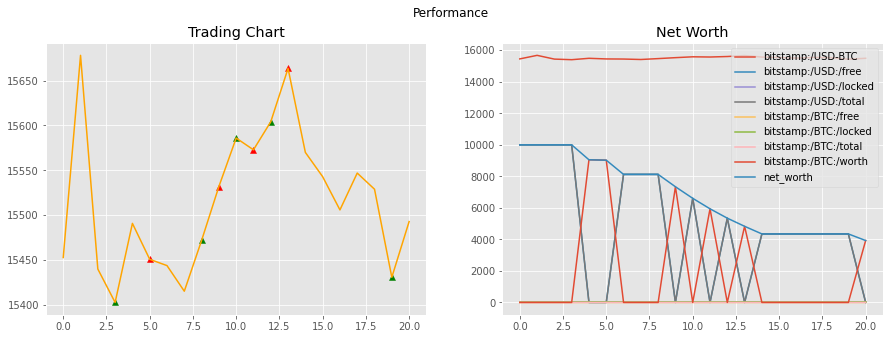

In [13]:
# Instantiate the environment
env = create_env(env_config_validation)

# Run until episode ends
done = False
obs = env.reset()
# Initialize hidden_state variable that will correspond to lstm_cell_size
hidden_state = [np.zeros(lstm_cell_size), np.zeros(lstm_cell_size)]

i = 0
while not done:
    # In order for use_lstm to work we set full_fetch to True
    # This changes the output of compute action to a tuple (action, hidden_state, info)
    # We also pass in the previous hidden state in order for the model to use correctly use the LSTM
    action, hidden_state, _ = agent.compute_action(obs, state=hidden_state, full_fetch=True)
    obs, reward, done, info = env.step(action)

env.render()